Copyright (c) Meta Platforms, Inc. and affiliates.
All rights reserved.
This source code is licensed under the license found in the
LICENSE file in the root directory of this source tree.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import numpy as np
import os
import requests

import torch
from torchvision.transforms.functional import to_tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def display_triplet_matplotlib(
    img1_tensor, img2_tensor, img3_tensor,
    pts1, pts2, pts3,
    save_path=None,
    color1="red", color2="green", color3="blue",
    radius=5, connect=True,
    title1=None, title2=None, title3=None
):
    """
    Display three images side-by-side with points and vector lines.
    Points are labeled p₁, p₂, ... on the first image, q₁, q₂, ... on the second, and 𝑝̂₁, 𝑝̂₂, ... on the third.
    Optionally saves the figure if save_path is provided.
    Points can be None to skip point display for that image.
    """
    def to_numpy_img(tensor_img):
        if hasattr(tensor_img, "dim") and tensor_img.dim() == 4:
            tensor_img = tensor_img[0]
        img = tensor_img.detach().cpu().numpy()
        if img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0, 1)
        return img

    imgs = [to_numpy_img(img1_tensor), to_numpy_img(img2_tensor), to_numpy_img(img3_tensor)]
    pts = [pts1, pts2, pts3]
    colors = [color1, color2, color3]
    titles = [title1, title2, title3]
    label_prefixes = ["p", "q", r"$\hat{p}$"]
    subscript_nums = ['₁', '₂', '₃', '₄']

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, img, points, color, title, prefix in zip(axes, imgs, pts, colors, titles, label_prefixes):
        ax.imshow(img)
        if points is not None and len(points) > 0:
            points = np.array(points)
            ax.scatter(points[:, 0], points[:, 1], s=radius**2, c=color, edgecolors='black', zorder=3)
            if connect and len(points) == 4:
                for i in range(4):
                    start = points[i]
                    end = points[(i+1)%4]
                    ax.annotate(
                        '', xy=end, xytext=start,
                        arrowprops=dict(arrowstyle='-', color=color, lw=2),
                        zorder=2
                    )
            for idx, (x, y) in enumerate(points):
                if prefix == r"$\hat{p}$":
                    label = r"$\hat{p}_{" + f"{idx+1}" + r"}$"
                else:
                    label = f"{prefix}{subscript_nums[idx]}" if idx < len(subscript_nums) else f"{prefix}{idx+1}"
                ax.text(
                    x + 6, y - 6, label, color='white', fontsize=24, zorder=4,
                    path_effects=[patheffects.withStroke(linewidth=1, foreground='white')]
                )
                ax.text(
                    x + 6, y - 6, label, color='black', fontsize=24, zorder=5
                )
        ax.set_axis_off()
        if title:
            ax.set_title(title, fontsize=14)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)

def random_crop_aug(img_tensor, min_param=0.5, max_param=0.9):
    """Apply random crop and return new corners. Scale is edge-wise"""
    B, C, H, W = img_tensor.shape
    scale = torch.rand(1).item() * (max_param - min_param) + min_param
    
    new_h, new_w = int(H * scale), int(W * scale)
    top = torch.randint(0, H - new_h + 1, (1,)).item()
    left = torch.randint(0, W - new_w + 1, (1,)).item()
    
    # Crop the image
    cropped = img_tensor[:, :, top:top+new_h, left:left+new_w]
    
    # Transform corners
    new_corners = np.array([
        [left, top],
        [left + new_w - 1, top],
        [left + new_w - 1, top + new_h - 1],
        [left, top + new_h - 1]
    ])
    return cropped, new_corners

def brightness_aug(img_tensor, min_param=0.5, max_param=1.5):
    """Apply random brightness change"""
    brightness_factor = torch.rand(1).item() * (max_param - min_param) + min_param
    return torch.clamp(img_tensor * brightness_factor, 0, 1)

def download_image(url, img_path):
    resp = requests.get(url)
    with open(img_path, "wb") as f:
        f.write(resp.content)
    return img_path

In [3]:
os.makedirs("images", exist_ok=True)
img_path = os.path.join("images", "squirrel.png")
download_image("https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1", img_path)

'images/squirrel.png'

In [ ]:
# Load model 
torchscript_path = "checkpoints/syncmodel_paper.jit.pt"
scripted = torch.jit.load(torchscript_path)

# Load and preprocess the image.
img_path = "images/squirrel.png"
img_size = 512  # or any size your model expects
original_size = (img_size, img_size)
corners = np.float32([
    [0, 0], # top-left,
    [img_size, 0], # top-right
    [img_size, img_size], # bottom-right
    [0, img_size]] # bottom-left
).reshape(-1, 1, 2)

img = Image.open(img_path).convert("RGB")
img = img.resize(original_size)
img_pt = to_tensor(img).unsqueeze(0).to(device)

Scripted model avg corner pixel error: 24.27


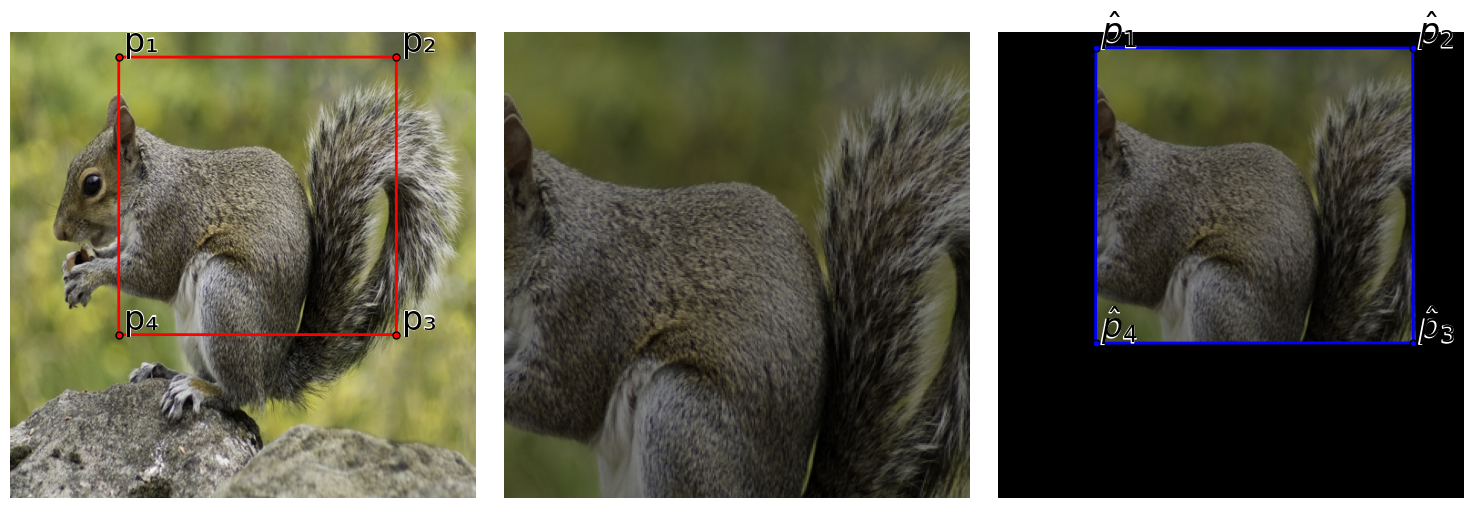

In [10]:
torch.manual_seed(0)  # for reproducibility

with torch.no_grad():
    emb = scripted.embed(img_pt)
    imgs_w = emb["imgs_w"]
    
    # Geometric aug - random crop
    imgs_geom, target_pts = random_crop_aug(imgs_w, min_param=0.5, max_param=0.7)

    # Valuemetric aug - brightness
    imgs_aug = brightness_aug(imgs_geom)
    
    det = scripted.detect(imgs_aug)
    pred_pts = det['preds_pts']  # Bx8 normalized [-1,1]
    # Unwarp
    imgs_unwarped = scripted.unwarp(imgs_aug, pred_pts, original_size) 

B, _, H, W = img_pt.shape
center_pt = torch.tensor([(W-1)/2, (H-1)/2], device=imgs_aug.device)
pred_pix = (pred_pts.view(B,4,2) * center_pt + center_pt).detach().cpu().numpy().tolist()[0]
avg_err = np.mean(np.linalg.norm(np.array(target_pts) - np.array(pred_pix), axis=1))
print(f"Scripted model avg corner pixel error: {avg_err:.2f}")

# Visualize: Original watermarked vs Augmented vs Unwarped
display_triplet_matplotlib(
    imgs_w[0], # first image
    imgs_aug[0],
    imgs_unwarped[0],
    target_pts, # points in first image
    None, # points in second image
    pred_pix, # points in third image
)

Example of failure case:

Scripted model avg corner pixel error: 188.78


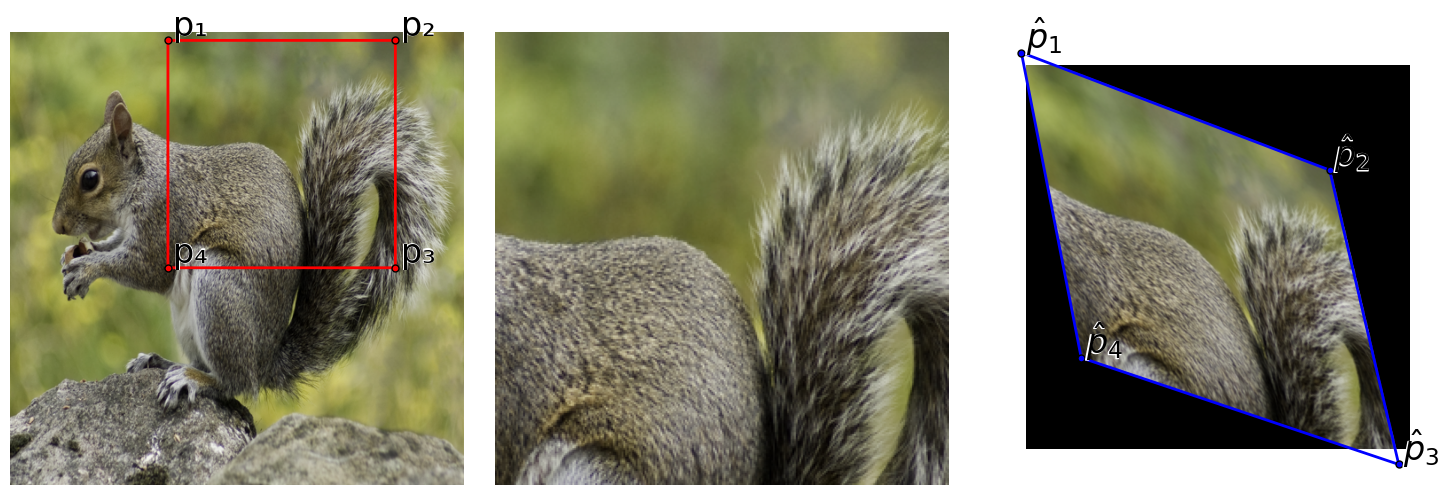

In [13]:
with torch.no_grad():
    emb = scripted.embed(img_pt)
    imgs_w = emb["imgs_w"]
    
    # Geometric aug - random crop
    imgs_geom, target_pts = random_crop_aug(imgs_w, min_param=0.5, max_param=0.7)

    # Valuemetric aug - brightness
    imgs_aug = brightness_aug(imgs_geom)
    
    det = scripted.detect(imgs_aug)
    pred_pts = det['preds_pts']  # Bx8 normalized [-1,1]
    # Unwarp
    imgs_unwarped = scripted.unwarp(imgs_aug, pred_pts, original_size) 

B, _, H, W = img_pt.shape
center_pt = torch.tensor([(W-1)/2, (H-1)/2], device=imgs_aug.device)
pred_pix = (pred_pts.view(B,4,2) * center_pt + center_pt).detach().cpu().numpy().tolist()[0]
avg_err = np.mean(np.linalg.norm(np.array(target_pts) - np.array(pred_pix), axis=1))
print(f"Scripted model avg corner pixel error: {avg_err:.2f}")

# Visualize: Original watermarked vs Augmented vs Unwarped
display_triplet_matplotlib(
    imgs_w[0], # first image
    imgs_aug[0],
    imgs_unwarped[0],
    target_pts, # points in first image
    None, # points in second image
    pred_pix, # points in third image
)